In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Read preprocessed data
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)

# Get rid of 'NaN' in text
df_new = my_df[my_df['text'].notnull()]
df_new.head()

/Users/apple/anaconda3/lib/python2.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


### Model 

In [3]:
x = df_new.text
y = df_new.target

In [4]:
from sklearn.model_selection import train_test_split
SEED = 2000

x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.2, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [5]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100)) 
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100)) 
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100)) 

Train set has total 1276832 entries with 49.97% negative, 50.03% positive
Validation set has total 159604 entries with 50.03% negative, 49.97% positive
Test set has total 159605 entries with 50.34% negative, 49.66% positive


In [6]:
# Training
from tqdm import tqdm
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [7]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [8]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596041/1596041 [00:01<00:00, 1348563.46it/s]


In [9]:
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 1596041/1596041 [00:01<00:00, 1327063.68it/s]


In [10]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596041/1596041 [00:01<00:00, 1241026.60it/s]


In [11]:
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 1596041/1596041 [00:01<00:00, 1392669.54it/s]


In [12]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

### Preparation

In [13]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 106259 word vectors.


In [14]:
# Tokenization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

len(tokenizer.word_index)

Using TensorFlow backend.


231740

In [27]:
# First five entries of original data
for x in x_train[:5]:
    print x

hey thnx for the wishes on me going indie the other day the breathing will soon turn into huffing puffing for clients
woken up by the sound of thunder today wow
mates house so can see eggnog again in morning saw him an hour or so ago haha eggnog eoghan factor
hello loving yer election buildup so far how are ya this morning
finished my lab report just need the worksheet anywaysi got janas straightner she gave it to me sounds likei stole it yay


In [28]:
# Data as sequential dats
sequences[:5]

[[141,
  2525,
  10,
  2,
  899,
  12,
  14,
  41,
  6321,
  2,
  248,
  29,
  2,
  4280,
  44,
  153,
  661,
  230,
  40242,
  23856,
  10,
  3184],
 [2209, 28, 117, 2, 620, 11, 1437, 37, 235],
 [2774,
  206,
  15,
  26,
  58,
  36468,
  99,
  9,
  89,
  267,
  138,
  87,
  338,
  96,
  15,
  442,
  97,
  36468,
  21247,
  4857],
 [424, 644, 2979, 4958, 53107, 15, 340, 63, 33, 239, 24, 89],
 [351,
  3,
  2427,
  1530,
  18,
  84,
  2,
  31178,
  93334,
  45,
  65852,
  23857,
  102,
  701,
  4,
  1,
  14,
  300,
  93335,
  2219,
  4,
  196]]

In [29]:
length = []
for x in x_train:
    length.append(len(x.split()))
    
max(length)

40

In [30]:
x_train_seq = pad_sequences(sequences, maxlen=45)
print('Shape of data tensor:', x_train_seq.shape)

('Shape of data tensor:', (1276832, 45))


In [19]:
x_train_seq[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,   141,  2525,    10,     2,
          899,    12,    14,    41,  6321,     2,   248,    29,     2,
         4280,    44,   153,   661,   230, 40242, 23856,    10,  3184],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         2209,    28,   117,     2,   620,    11,  1437,    37,   235],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  2774,   206,
           15,    26,    58, 36468,    99,     9,    89,   267,   138,
    

In [20]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=45)

In [31]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [32]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [33]:
# 
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1276832 samples, validate on 159604 samples
Epoch 1/5
 - 843s - loss: 0.4641 - acc: 0.7779 - val_loss: 0.4468 - val_acc: 0.7889
Epoch 2/5
 - 806s - loss: 0.4261 - acc: 0.8016 - val_loss: 0.4461 - val_acc: 0.7906
Epoch 3/5
 - 864s - loss: 0.3945 - acc: 0.8198 - val_loss: 0.4577 - val_acc: 0.7893
Epoch 4/5
 - 840s - loss: 0.3622 - acc: 0.8376 - val_loss: 0.4724 - val_acc: 0.7865
Epoch 5/5
 - 825s - loss: 0.3322 - acc: 0.8532 - val_loss: 0.5055 - val_acc: 0.7807


In [36]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, input_length=45)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1276832 samples, validate on 159604 samples
Epoch 1/5
 - 7619s - loss: 0.4267 - acc: 0.8034 - val_loss: 0.4049 - val_acc: 0.8169
Epoch 2/5
 - 7078s - loss: 0.3703 - acc: 0.8352 - val_loss: 0.4060 - val_acc: 0.8176
Epoch 3/5
 - 7059s - loss: 0.3132 - acc: 0.8647 - val_loss: 0.4411 - val_acc: 0.8088
Epoch 4/5
 - 7082s - loss: 0.2539 - acc: 0.8936 - val_loss: 0.4918 - val_acc: 0.7975
Epoch 5/5
 - 7084s - loss: 0.2054 - acc: 0.9156 - val_loss: 0.5701 - val_acc: 0.7901


In [37]:
model_ptw2v = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1276832 samples, validate on 159604 samples
Epoch 1/5
 - 7175s - loss: 0.4267 - acc: 0.8026 - val_loss: 0.4081 - val_acc: 0.8156
Epoch 2/5
 - 7277s - loss: 0.3774 - acc: 0.8310 - val_loss: 0.4086 - val_acc: 0.8183
Epoch 3/5
 - 7372s - loss: 0.3333 - acc: 0.8542 - val_loss: 0.4337 - val_acc: 0.8139
Epoch 4/5
 - 7574s - loss: 0.2805 - acc: 0.8802 - val_loss: 0.4670 - val_acc: 0.8072
Epoch 5/5
 - 7345s - loss: 0.2313 - acc: 0.9033 - val_loss: 0.5430 - val_acc: 0.8000


### Convolutional Neural Network

In [24]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [38]:
structure_test = Sequential()
e = Embedding(100000, 200,input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 100)           40100     
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [39]:
structure_test = Sequential()
e = Embedding(100000, 200, input_length=45)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 45, 200)           20000000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 44, 100)           40100     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
Total params: 20,040,100
Trainable params: 20,040,100
Non-trainable params: 0
_________________________________________________________________


In [40]:
model_cnn_01 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(1, activation='sigmoid'))
model_cnn_01.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1276832 samples, validate on 159604 samples
Epoch 1/5
 - 578s - loss: 0.4201 - acc: 0.8058 - val_loss: 0.4097 - val_acc: 0.8119
Epoch 2/5
 - 575s - loss: 0.3986 - acc: 0.8187 - val_loss: 0.3976 - val_acc: 0.8201
Epoch 3/5
 - 579s - loss: 0.3913 - acc: 0.8227 - val_loss: 0.3934 - val_acc: 0.8217
Epoch 4/5
 - 577s - loss: 0.3869 - acc: 0.8250 - val_loss: 0.3941 - val_acc: 0.8225
Epoch 5/5
 - 584s - loss: 0.3838 - acc: 0.8267 - val_loss: 0.3950 - val_acc: 0.8232


In [42]:
model_cnn_02 = Sequential()
e = Embedding(100000, 200, input_length=45)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(1, activation='sigmoid'))
model_cnn_02.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1276832 samples, validate on 159604 samples
Epoch 1/5
 - 7525s - loss: 0.4139 - acc: 0.8097 - val_loss: 0.3956 - val_acc: 0.8200
Epoch 2/5
 - 7093s - loss: 0.3628 - acc: 0.8391 - val_loss: 0.3878 - val_acc: 0.8245
Epoch 3/5
 - 6953s - loss: 0.3271 - acc: 0.8588 - val_loss: 0.3942 - val_acc: 0.8249
Epoch 4/5
 - 6954s - loss: 0.2933 - acc: 0.8766 - val_loss: 0.4145 - val_acc: 0.8193
Epoch 5/5
 - 6976s - loss: 0.2631 - acc: 0.8914 - val_loss: 0.4361 - val_acc: 0.8149


In [43]:
model_cnn_03 = Sequential()
e = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(1, activation='sigmoid'))
model_cnn_03.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 1276832 samples, validate on 159604 samples
Epoch 1/5
 - 6982s - loss: 0.4064 - acc: 0.8139 - val_loss: 0.3923 - val_acc: 0.8235
Epoch 2/5
 - 7349s - loss: 0.3674 - acc: 0.8365 - val_loss: 0.3821 - val_acc: 0.8295
Epoch 3/5
 - 9299s - loss: 0.3399 - acc: 0.8514 - val_loss: 0.3885 - val_acc: 0.8280
Epoch 4/5
 - 7174s - loss: 0.3136 - acc: 0.8653 - val_loss: 0.3988 - val_acc: 0.8259
Epoch 5/5
 - 8983s - loss: 0.2872 - acc: 0.8786 - val_loss: 0.4100 - val_acc: 0.8215


In [25]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

In [44]:
tweet_input = Input(shape=(45,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)(tweet_input)

bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)

trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)

fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)

merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 45, 200)      20000000    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 44, 100)      40100       embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 43, 100)      60100       embedding_13[0][0]               
__________________________________________________________________________________________________
conv1d_9 (

In [46]:
# Saving trained weights
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Train on 1276832 samples, validate on 159604 samples
Epoch 1/5
1276832/1276832 [==============================] - 12104s 9ms/step - loss: 0.4068 - acc: 0.8161 - val_loss: 0.3845 - val_acc: 0.8287

Epoch 00001: val_acc improved from -inf to 0.82866, saving model to CNN_best_weights.01-0.8287.hdf5
Epoch 2/5
1276832/1276832 [==============================] - 11796s 9ms/step - loss: 0.3664 - acc: 0.8392 - val_loss: 0.3970 - val_acc: 0.8305

Epoch 00002: val_acc improved from 0.82866 to 0.83050, saving model to CNN_best_weights.02-0.8305.hdf5
Epoch 3/5
1276832/1276832 [==============================] - 10981s 9ms/step - loss: 0.3366 - acc: 0.8547 - val_loss: 0.3903 - val_acc: 0.8292

Epoch 00003: val_acc did not improve from 0.83050
Epoch 4/5
1276832/1276832 [==============================] - 10904s 9ms/step - loss: 0.3034 - acc: 0.8717 - val_loss: 0.3935 - val_acc: 0.8276

Epoch 00004: val_acc did not improve from 0.83050
Epoch 5/5
1276832/1276832 [==============================] - 11214s 

In [49]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.02-0.8305.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

159604/159604 [==============================] - 78s 489us/step


[0.3969811671721464, 0.8304992356096239]

### Model evaluation

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.float64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [52]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [54]:
from sklearn.linear_model import LogisticRegression

lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)

/Users/apple/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [55]:
lr_with_tfidf.score(x_test_tfidf,y_test)

0.8248363146517966

In [56]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [57]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

159605/159605 [==============================] - 75s 470us/step


[0.3945501059690539, 0.8313962595167997]

In [59]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

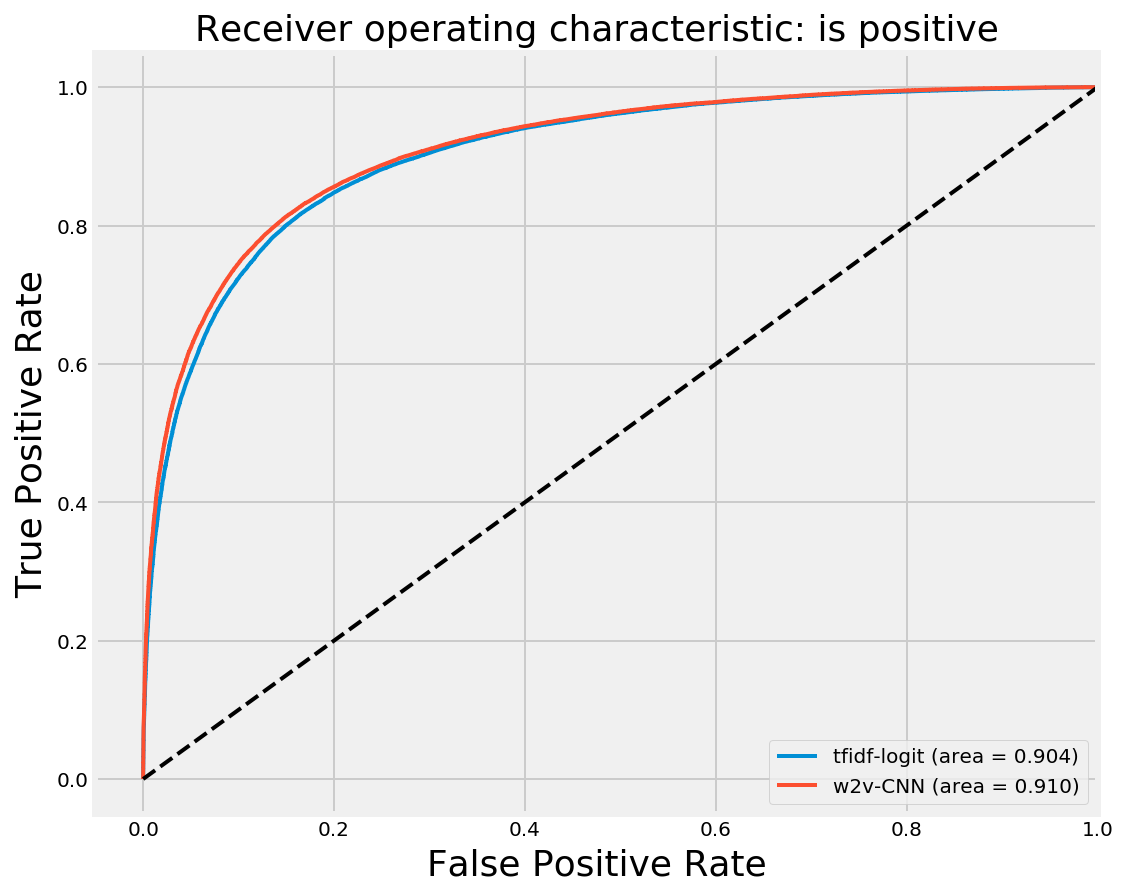

In [60]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()